In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

from sklearn import svm
from sklearn.decomposition import PCA

In [2]:
#read the consolidated data file
'''for the purpose of this demo we use a fake datafile generated in fake_data_generation'''
fname = 'fakedata'
data = pd.read_csv(fname+".csv")
# print(data.columns)
data.head()

,latitude,longitude,datetime,X1,X2,X3
0,22.614679,50.822511,999.151107,-7.848408,-5.247848,-4.566957
1,21.377451,50.777432,1001.883175,-5.016138,-6.087626,-5.851425
2,17.454317,48.014107,999.048326,-3.613127,-5.786696,-7.039579
3,19.155321,49.371672,999.770497,-8.338071,-1.750587,-6.784620
4,20.846455,49.501044,1001.081442,-7.799518,-8.253047,-6.600085


In [3]:
# get the variables - all columns without latitude, longitude and time
X_raw=data.as_matrix()
X_raw= X_raw[:,3:]

#look at it
print(X_raw[:6,:])

###### pca - dimention reduction to two dimentian 
pca = PCA(n_components=2)
X=pca.fit_transform(X_raw)


[[-7.84840818 -5.24784814 -4.56695656]
 [-5.01613788 -6.08762596 -5.85142493]
 [-3.61312733 -5.78669571 -7.03957867]
 [-8.33807101 -1.7505871  -6.7846199 ]
 [-7.79951808 -8.25304673 -6.60008467]
 [-4.74036455 -5.87572466 -7.24718516]]


In [4]:
# we will mark the oddest 10% of entries as anomalies
outliers_fraction=0.1
model=svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,  kernel="rbf", gamma=0.1).fit(X)
print(model)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.14500000000000002, random_state=None,
      shrinking=True, tol=0.001, verbose=False)


In [5]:
#predicted score of a point NOT being an outlier
y_pred = model.decision_function(X).ravel()


In [6]:
##potentially we can let user to change the treshhold
threshold = stats.scoreatpercentile(y_pred,100 * outliers_fraction)
print(threshold)

-0.00028516632592


In [7]:
y_pred = y_pred <= threshold
# print(y_pred)

In [8]:
#save original data and a flag=1 if the point is an outlier
X_new = np.c_[X, y_pred]
# print(min(X[:,1]))
print(X_new[:5, :])

[[-10.35867238  -2.91776189   0.        ]
 [-10.04968178   0.1969009    0.        ]
 [ -9.82784682   1.9799328    0.        ]
 [-10.00468249  -2.41776959   0.        ]
 [-13.2740503   -1.27997565   0.        ]]


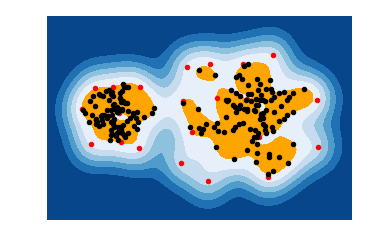

In [9]:
#plotting the stuff
marg=5
xx, yy = np.meshgrid(np.linspace(min(X[:,0])-marg, max(X[:,0])+marg, 500), np.linspace(min(X[:,1])-marg, max(X[:,1])+marg, 500))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()

#contour lines for outlier detection
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

#scatterplot of the data

plt.scatter(X_new[X_new[:, 2] == 1][:, 0], X_new[X_new[:, 2] == 1][:, 1], color='red', label='inliers')
plt.scatter(X_new[X_new[:, 2] == 0][:, 0], X_new[X_new[:, 2] == 0][:, 1], color='black', label='inliers')
plt.axis('off')
plt.show()

In [10]:
#add a column with outlier flag ot the data
data['outlier']=X_new[:, 2].astype(int)
data.head()

,latitude,longitude,datetime,X1,X2,X3,outlier
0,22.614679,50.822511,999.151107,-7.848408,-5.247848,-4.566957,0
1,21.377451,50.777432,1001.883175,-5.016138,-6.087626,-5.851425,0
2,17.454317,48.014107,999.048326,-3.613127,-5.786696,-7.039579,0
3,19.155321,49.371672,999.770497,-8.338071,-1.750587,-6.784620,0
4,20.846455,49.501044,1001.081442,-7.799518,-8.253047,-6.600085,0


In [11]:
#convert output to json and save it
output=data.to_json(orient="records")

f = open('website_data.js', 'w')
f.write('var outlier = ' + output + ";")
f.close()

